In [21]:
from langgraph.graph import StateGraph,START,END

from langgraph.types import Literal,Command
from langchain_core.messages import AIMessage, HumanMessage,SystemMessage,BaseMessage
from langchain_community.chat_models import ChatZhipuAI
from pydantic import BaseModel,Field
from typing import TypedDict,Annotated
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser,JsonOutputParser
from langgraph.graph.message import add_messages
from prompt.system_prompt import SYSTEM_PROMPT,LAST_WORDS_PROMPT,DISCUSSION_PROMPT,VOTE_PROMPT
from prompt.seer_prompt import SEER_KILL_PROMPT,SEER_PROMPT
from prompt.villager_prompt import VILLAGER_PROMPT
from prompt.witch_prompt import WITCH_KILL_PROMPT,WITCH_PROMPT
from prompt.wolf_prompt import WOLF_PROMPT,WOLF_REASON_PROMPT,WOLF_VOTE_PROMPT
from prompt.game_master_prompt import DEALER_PROMPT
from prompt.messages_manager_prompt import SUMMARY_PROMPT
from langchain.chat_models import ChatOpenAI
from langchain_core.output_parsers import PydanticOutputParser

import operator
import random
import re  #正则表达式  用来从文本中提取玩家信息  1号玩家


# 首先创建狼人杀 上帝 智能体

In [22]:
def getdeep():
    return ChatOpenAI(api_key="sk-a8a9c5b2cf0a46319ed2894b39c8422d",base_url="https://api.deepseek.com",model="deepseek-chat",temperature=0.0)
def getzhipu():
    return ChatZhipuAI(temperature=0.0,model='glm-4-flash')
def openai():
    return ChatOpenAI(temperature=0.0,api_key="sk-uL7ptfo0PW7O96at3LwQ6xVVpLCHrz0vNMvovImoITl5DQ5N",base_url="https://www.DMXapi.com/v1/",model="gpt-3.5-turbo")


message_agent = getdeep() # 负责优化消息

class GameAgent:
    def __init__(self, name,background_prompt):
        self.content = f"游戏背景：{SYSTEM_PROMPT} \n\n 你是{name}\n\n{name}的背景信息如下：{background_prompt}\n\n"
        self.prompt = ChatPromptTemplate.from_messages([SystemMessage(content=self.content), ("placeholder", "{messages}")])
        self.agent = self.prompt | getdeep()
        self.messages=[] # 存放自己聊天历史
    def __call__(self, prompt:list):
        history = self.messages
        resopnose = self.agent.invoke({"messages":history+prompt})
        self.messages.append(resopnose)
        self.clear_messages()
        return resopnose.content
    def clear_messages(self):
        if len(self.messages)>6:
            content = SUMMARY_PROMPT.format(messages = self.messages)
            human_message = HumanMessage(content = content)
            response = message_agent.invoke([human_message])
            self.messages = [response.content]
            print(f"==消息整理完毕==")

class Player:
    def __init__(self, name,role: str, friends: list = []):
        self.name=name    # 玩家名称  1号玩家  、2号玩家  、 3号玩家 
        self.role = role  # 角色 
        self.friends = friends # 存放朋友的索引
        self.life = 1 # 玩家生命值 为 1 表示玩家存活
    def __hash__(self):
        return hash(self.name)  # 使用玩家名字作为唯一标识
    def __eq__(self, other):
        return self.name == other.name  # 比较角色名称是否相同
class GameMaster:
    def __init__(self, role_list: list, info):
        self.witch = 1 # 1 表示女巫还未使用技能  0表示女巫已使用技能
        self.role_dict = dict() # 角色列表
        self.wolfs_count = 2 # 狼人数量
        self.villagers_count = 2 # 村民数量
        self.agent = self.get_gm_agent(info)
        wolf_index = []
        wolf_info = ""
        for i,role in enumerate(role_list):
            if role=="狼人":
                wolf_index.append(i)
                wolf_info +=  f"{i+1}号玩家、"
        wolf_info = "狼人阵营:"+wolf_info
        for i,role in enumerate(role_list):
            name = f"{i+1}号玩家"
            if role=="狼人":    
                self.role_dict[Player(name=name,role=role,friends=wolf_index)]=GameAgent(wolf_info+name,WOLF_PROMPT)
            elif role=="预言家":
                self.role_dict[Player(name=name,role=role,friends=[])]=GameAgent(name,SEER_PROMPT)
            elif role=="女巫":
                self.role_dict[Player(name=name,role=role,friends=[])]=GameAgent(name,WITCH_PROMPT)
            else: # 村民
                self.role_dict[Player(name=name,role=role,friends=[])]=GameAgent(name,VILLAGER_PROMPT)
    def get_gm_agent(self,info:str):
        content = DEALER_PROMPT+"玩家的身份信息："+info
        system_messgage = SystemMessage(content=content)
        prompt = ChatPromptTemplate.from_messages([system_messgage, ("placeholder", "{messages}")])
        agent = prompt|openai()
        return agent
    def get_game_maser_agent(self):
        return self.agent
    def get_seer(self):
        for  player,agent in self.role_dict.items():
            if player.role=="预言家" and player.life==1:
                return (player,agent)
        return None
    def get_witch(self):
        for  player,agent in self.role_dict.items():
            if player.role=="女巫" and player.life==1:
                return (player,agent)
        return None
    def get_life_players(self)->list:# 获取存活的玩家的名称  例如 【1号玩家、2号玩家、3号玩家】
        life_players = []
        for player,agent in self.role_dict.items():
            if player.life==1:
                life_players.append(player.name)
        return life_players
    def kill_player_by_names(self,names:list): # 根据名称杀死玩家
        for player,agent in self.role_dict.items():
            if player.name in names:
                player.life = 0
                if player.role=="狼人":
                    
                    self.wolfs_count -= 1
                if player.role=="村民":
                    self.villagers_count -= 1
    def un_kill_player_by_names(self,names:list): # 根据名称取消杀死玩家
        for player,agent in self.role_dict.items():
            if player.name in names:
                player.life = 1
                if player.role=="狼人":
                    self.wolfs_count += 1
                if player.role=="村民":
                    self.villagers_count += 1
    def get_witch_life_info(self)->bool:
        for player,agent in self.role_dict.items():
            if player.role=="女巫" and player.life==1:
                return True
        return False
    def get_seer_life_info(self)->bool:
        for player,agent in self.role_dict.items():
            if player.role=="预言家" and player.life==1:
                return True
        return False
    def get_wolfs(self)->dict: 
        wolfs = dict()
        for player,agent in self.role_dict.items():
            if player.role=="狼人" and player.life == 1:
                wolfs[player]=agent
        return wolfs
    def generate_text_by_list(self,data:list)->str:

        text = ""
        if len(data)==0:
            return text
        for d in data:
            text+=str(d)
            text+="\n"
        return text
    def get_vote_result(self,vote_list):
        """
        parms : vote_list
        
        returns name 
        """
        name_count = dict()
        for name in vote_list:
            if name=='no':          #弃权
                continue
            if name not in name_count:
                name_count[name]=1
            else:
                name_count[name]+=1
        sorted_votes = sorted(name_count.items(), key=lambda x: x[1], reverse=True)
        print(sorted_votes)
        return sorted_votes[0][0] 
    def get_player_agent_by_name(self,name): #  获取发表遗言的玩家和agent
        for player,agent in self.role_dict.items():
            if player.name==name and player.life==1:
                return player,agent
    def game_over(self)->bool:
        if self.wolfs_count==0 or self.villagers_count==0:
            return True
        else:
            return False

# 发牌员和玩家的全局状态
class State(TypedDict):
    """
    1. messages: 定义全局状态, 用于存储角色之间聊天记录
    2. god_messages: 存储上帝（发牌员）的信息
    3. light: 记录当前是白天还是黑夜
    """
    gm:GameMaster
    messages: Annotated[list, operator.add]       # 存储玩家之间的聊天记录
    wolf_messages: Annotated[list, add_messages] #存储狼人的消息
    light: bool  # True 代表白天，False 代表黑夜
    vote_list:list # 投票的人的玩家名称 1号玩家、2号玩家、3号玩家
    witch_kill:bool 
    die_roles:dict # 存放每晚毒杀的玩家
    # vote_parser:PydanticOutputParser
    # discussion_parser:PydanticOutputParser
    # role_parser:PydanticOutputParser

In [23]:
gm = GameMaster([],"1号是村民")

In [24]:
agent = gm.agent
agent.invoke({"messages":[HumanMessage("告诉我1号的身份")]})

AIMessage(content='1号玩家是“村民”。', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 542, 'total_tokens': 551, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': 'fp_b705f0c291', 'finish_reason': 'stop', 'logprobs': None}, id='run-c98f3774-55fd-40f8-91a0-724190889982-0')

# agent思路： 发牌员 和 玩家  智能体 
1. 初始化
- 角色分配 & 创建智能体
- 初始化全局状态 & 玩家状态
2. 夜晚阶段
- GM 控制游戏流程
- 狼人投票
- 预言家查验
-女巫救人
3. 白天阶段
 玩家讨论 & 投票驱逐
4. 游戏循环
- 不断重复夜晚 -> 白天，直到游戏结束

# 图中的节点

In [25]:
def init_game(state:State):
    roles =["村民","村民","狼人","预言家","女巫","狼人"]
    random.shuffle(roles)
    human_content =""
    for i in range(len(roles)):
        info = f"{i+1}号玩家的身份是{roles[i]}\n"
        human_content += info
    human_messages = HumanMessage(content=human_content)
    gm = GameMaster(roles,info)
    # 创建格式解析
    # discussion_parser = PydanticOutputParser(pydantic_object=Discussion)
    # role_parser = PydanticOutputParser(pydantic_object=Role)
    # vote_parser = PydanticOutputParser(pydantic_object=Vote)
    return {"light":False,"gm":gm}
# 开始游戏
def start_game(state:State) ->Command[Literal["wolf_node","light_discussion","game_over"]]:
    gm = state['gm']
    if gm.game_over():
        goto = "game_over" # 进入 游戏结束缓解，分析该局是哪一方赢了
        
        return Command(update=None,goto=goto) 
    if state['light'] == False:
        print("天黑请闭眼，请狼人行动")
        return Command(update=None,goto="wolf_node")
    else:
        print("天亮了")
        goto = "light_discussion"
        return Command(update=None,goto=goto)
# 狼人行动
def wolf_node(state:State):
    
    new_wolf_messages = []                              #  保存本次夜晚狼人交流的信息
    gm = state['gm']                                    # 获取发牌员对象 
    wolf_messages = state['wolf_messages']              # 获取狼人交流的信息
    messages = state['messages']                        # 获取玩家交流的信息
    wolf_dict = gm.get_wolfs()                          # 获取目前存活的狼人列表   
    life_player_names = gm.get_life_players()              # 获取目前存活的玩家列表
    # 狼人交流2次  
    for _ in range(2):
        for wolf,wolf_agent  in wolf_dict.items():

            wolf_template = WOLF_REASON_PROMPT.format(life_role=life_player_names,wolf_messages=wolf_messages,messages=messages+new_wolf_messages)
            human_message = HumanMessage(wolf_template)
            wolf_response = wolf_agent([human_message])
            print(f"==={wolf.name}发言:{wolf_response}===")
            new_wolf_messages.append(f"{wolf.name}发言:{wolf_response}")
    # 狼人投票
    vote_list = []
    for wolf,wolf_agent in wolf_dict.items():
        vote_prompt = WOLF_VOTE_PROMPT.format(life_role=life_player_names,wolf_messages=wolf_messages,messages=messages)
        human_message = HumanMessage(vote_prompt)
        wolf_response = wolf_agent([human_message])
      
        print(f"===狼人:{wolf.name}的投票结果:{wolf_response}===")
        vote_list.append(wolf_response)

    player_name = gm.get_vote_result(vote_list)
    
    die_dict = dict()
    die_dict[player_name] ="狼人杀害"
    
    return {"wolf_messages":new_wolf_messages,"die_roles":die_dict,"vote_list":vote_list}
    
# 预言家行动
def seer_node(state:State):
    gm = state['gm']
    seer_player,seer_agent = gm.get_seer()
    messages = state['messages']                                # 获取玩家交流的信息
    life_player_names = gm.get_life_players()                   # 获取目前存活的玩家列表

    # 预言家发动技能
    content = SEER_KILL_PROMPT.format(life_role=life_player_names,messages=messages)
    human_message = {"role":"user","content":content}

    seer_question = seer_agent([human_message])                 # 让预言家生成询问的语句 比如 我想要知道 1号玩家的身份
    print(f"===预言家发动技能:{seer_question}===")
     # 1.获取发牌员智能体
    gm_agent = gm.get_game_maser_agent()
    human_message = HumanMessage(content= seer_question)
    # 2.询问发牌员玩家身份
    gm_response = gm_agent.invoke({"messages":[human_message]}).content
    print(f"===预言家得知信息:{gm_response}==")
    # 3.将玩家信息告知预言家
    seer_agent([{"role":"human","content":gm_response}])
    return {}
# 女巫行动
def witch_node(state:State):
    gm = state['gm']
    messages = state['messages']

    die_dict=dict()
    life_player_names = gm.get_life_players()             # 获取目前存活的玩家列表
    witch_player,witch_agent = gm.get_witch()
    # 获取狼人的投票
    wolf_vote_list = state['vote_list']
    print("狼人投票结果",wolf_vote_list)
    attacked_player_name = gm.get_vote_result(wolf_vote_list)
    content = WITCH_KILL_PROMPT.format(life_role=life_player_names,messages=messages,attacked_player=(attacked_player_name))
    human_message = HumanMessage(content=content)
    response = witch_agent([human_message])
    
    witch_kill = True
    if "不" in response:
        
       content = f"===今晚，女巫没有发动技能,狼人杀了{attacked_player_name}==="
       
       die_dict[attacked_player_name] = "狼人杀害"
       print(content)
    #    gm.kill_player_by_names([attacked_player_name])
    elif "毒药" in response:
        witch_kill = False
        start = response.find("毒死") + len("毒死")
        play_name = response [start:start+4]
        content = f"===女巫：今晚，两个人被杀了，女巫针对{play_name}使用了毒药，狼人杀了 {attacked_player_name}==="
    
        
        die_dict[attacked_player_name]="狼人杀害"
        die_dict[play_name]="女巫毒死"
        print(content)
    else:# 解药
        witch_kill=False
        start = response.find("救活") + len("救活")
        play_name = response [start:start+4]
        assert(play_name==attacked_player_name)
        ai_message = f"今晚，狼人杀害的目标是{attacked_player_name},我对{play_name}使用了解药"
        print(f"===女巫：今晚，狼人杀害的目标是{attacked_player_name},我对{play_name}使用了解药===")
        gm.un_kill_player_by_names([attacked_player_name])
    message = HumanMessage(content=ai_message)
    witch_agent([message])
    return {"gm":gm,"die_roles":die_dict,"witch_kill":witch_kill}  
# 夜晚总结
def dark_over(state:State):
    # 请夜晚出局的人员发表遗言
    temp_messages = []
    gm = state['gm']
    messages =state['messages']
    die_dict = state['die_roles']
    life_player_names = gm.get_life_players() 
    if die_dict:
        for name,reason in die_dict.items():
            content = LAST_WORDS_PROMPT.format(death_reason=reason,life_role=life_player_names,messages=messages+temp_messages)
            human_message = HumanMessage(content=content)
            player,agent = gm.get_player_agent_by_name(name)
            response = agent([human_message])
            temp_messages.append(f"{player.name}的身份：{player.role} ，发表遗言：{response}")
            gm.kill_player_by_names([name])
            print(f"==={player.name}的身份：{player.role} ，发表遗言：{response}===")

    return {"light":True,"messages":temp_messages,"gm":gm} # 切换为白天 游戏重新开始
    
def light_discussion(state:State):
    messages = state['messages']
    temp_messages=[]
    gm = state['gm']
    life_player_names = gm.get_life_players()
    temp_messages = []
    player_dict = gm.role_dict # key 为玩家名称，value 为玩家
    for player,agent in player_dict.items():
        if player.life==0:
            continue
        player_name = player.name
        discussion_prompt = DISCUSSION_PROMPT.format(life_roles=life_player_names,messages =messages+temp_messages)
        human_messages = HumanMessage(content=discussion_prompt)
        response = agent([human_messages])
        temp_messages.append(f"{player_name}：{response}")
        print(f"==={player_name}发表意见：{response}===")
    return {"messages":temp_messages}
# 进入投票环节
def light_over(state:State):
    gm = state['gm']
    messages = state['messages']
    temp_messages = []
    player_dict = gm.role_dict # key 为玩家名称，value 为玩家
    vote_list = []
    life_player_names = gm.get_life_players()
    for player,agent in player_dict.items():
        if player.life==0:
            continue
        player_name = player.name
        vote_prompt = VOTE_PROMPT.format(life_roles=life_player_names,messages=messages)
        human_message = HumanMessage(content=vote_prompt)
        response = agent([human_message])
        vote_list.append(response)
        print(f"==={player_name} 投票:{response}===")
    # 获取最多票的玩家
    player_name = gm.get_vote_result(vote_list)
    
    # 发表遗言
    player,player_agent = gm.get_player_agent_by_name(player_name)
    # 将该玩家t出局
    gm.kill_player_by_names([player_name])
    life_player_names = gm.get_life_players()

    last_contet = LAST_WORDS_PROMPT.format(death_reason="多人投票出局",life_role=life_player_names,messages=messages+temp_messages)
    human_message = HumanMessage(content = last_contet)
    response = player_agent([human_message])
    temp_messages.append(f"{player_name}的遗言:{response}")
    
    print(f"==={player_name}:身份:{player.role} 发表遗言:{response}===")
    return {"messages":temp_messages,"light":False,"gm":gm} 
def game_over(state:State):
    # 游戏结束 
    gm = state['gm']
    wolfs_count = gm.wolfs_count
    villagers_count = gm.villagers_count
    if wolfs_count == 0:
        print("===好人获胜===")
    elif villagers_count == 0:
        print("===狼人获胜===")
    print("===游戏结束===")
    print("===游戏结束存活的玩家====")
    for player,agent in gm.role_dict.items():
        if player.life==0:
            continue
        player_name = player.name
        print(f"==={player_name}身份:{player.role}===")
    return {}

# 创建条件边 判断函数

In [26]:
# 判断预言家or女巫是否存活
def judge_wolf_to_seer_or_witch_or_dark_over(state:State):
    gm = state['gm']
    seer_info = gm.get_seer()
    if seer_info is not None:
         return "seer_node"
    witch_info = gm.get_witch()
    if witch_info is not None and state['witch_kill']:
        return "witch_node"
    return "dark_over"

# 预言家到女巫的边的判断函数
def judge_seer_to_witch_or_dark_over(state:State):
    gm = state['gm']
    witch_info = gm.get_witch()
    if witch_info is not None:
        return "witch_node"
    return "dark_over"


In [27]:

graph_builder = StateGraph(state_schema=State)
graph_builder.add_node("init_game",init_game)
graph_builder.add_node("start_game",start_game)
graph_builder.add_node("wolf_node",wolf_node)
graph_builder.add_node("seer_node",seer_node)

graph_builder.add_node("witch_node",witch_node)
graph_builder.add_node("dark_over",dark_over)
graph_builder.add_node("light_discussion",light_discussion)
graph_builder.add_node("light_over",light_over)
graph_builder.add_node("game_over",game_over)

graph_builder.add_edge(START,"init_game")
graph_builder.add_edge("init_game","start_game")

graph_builder.add_conditional_edges("wolf_node",judge_wolf_to_seer_or_witch_or_dark_over,["seer_node","witch_node","dark_over"])
graph_builder.add_conditional_edges("seer_node",judge_seer_to_witch_or_dark_over,["witch_node","dark_over"])
graph_builder.add_edge("witch_node","dark_over")

# 黑夜 到 游戏开始
graph_builder.add_edge("dark_over","start_game")


# 白天的边
graph_builder.add_edge("light_discussion","light_over")
# 创建投票完到游戏开始的边
graph_builder.add_edge("light_over","start_game")
graph_builder.add_edge("game_over",END)
graph = graph_builder.compile()

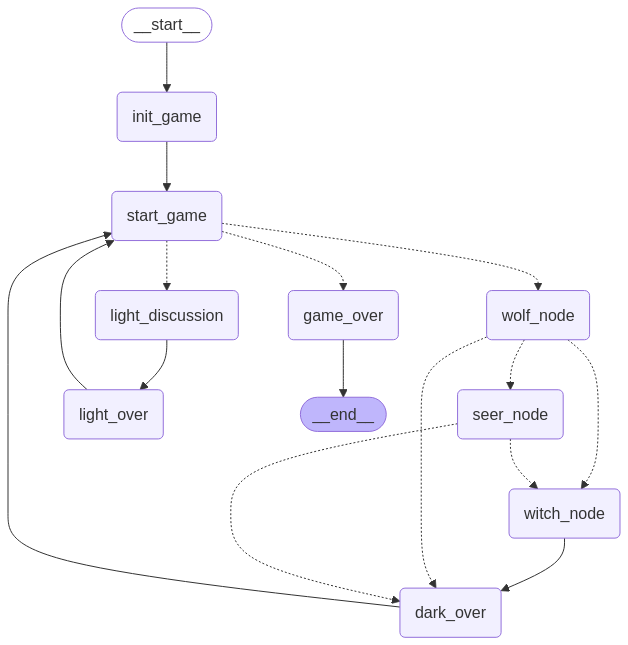

In [28]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [29]:
init_state={
    "gm":None,
    "messages":[],
    "wolf_messages":[],
    "light":False,
    "vote_list":[],
    "witch_kill":True,
    "die_roles":[]

}
graph.invoke(init_state)

天黑请闭眼，请狼人行动
===1号玩家发言:我是1号玩家，我的发言如下所示：

兄弟们，现在场上6人存活，我们狼队有2票优势。我建议今晚刀4号，他发言一直比较划水，很可能是神职在隐藏身份。白天我们可以先观察2号和5号的动向，2号昨天发言有点紧张，可以试着往他身上泼脏水。3号你等下可以带节奏说听到2号半夜有动静，我来附和。女巫大概率还有药，如果4号是神职被刀，女巫可能会救，这样我们明天就能锁定女巫身份。这轮先别急着冲票，避免暴露，稳扎稳打。===
===3号玩家发言:我是3号玩家，我的发言如下所示：

1号玩家的策略我觉得很合理。4号确实一直划水，很可能是藏着身份的神职，刀他是最优解。关于白天的战术，我完全同意1号的安排，我会重点观察2号的表现，他昨天的发言确实有点紧张，我可以带节奏说他半夜有动静。不过建议我们不要表现得太明显，可以先让好人内部互相怀疑。 

另外我注意到5号玩家昨天投票时有些犹豫，这个点也可以利用起来。明天我们可以暗示5号和2号可能是狼队友，制造他们之间的对立。女巫如果救4号，那我们就锁定4号是神职，如果没救就更好了。这轮我们稳一点，不要急着冲票，避免暴露狼队格局。

今晚就按1号说的刀4号，白天看情况决定是否推2号或者5号。大家保持默契，别露出破绽。===
===1号玩家发言:我是1号玩家，我的发言如下所示：

3号兄弟的思路很清晰，我们配合得很默契。既然都同意刀4号，那今晚就锁定4号。我补充几点战术细节：

1. 明天如果4号倒牌，女巫没救的话，我们可以顺势把4号包装成被狼队自刀的神职，这样能污一波好人视角。

2. 关于2号和5号，我观察到6号昨天发言时特别关注5号，这是个可以利用的点。明天可以让3号带节奏说"6号这么关注5号是不是在保狼队友"，制造他们之间的矛盾。

3. 我建议明天发言顺序上，3号先跳出来质疑2号，我随后附和但表现得犹豫一些，这样显得我们不是一伙的。最后看情况决定是否把矛头转向5号或6号。

4. 如果女巫救了4号，我们就得改变策略，可以假装怀疑女巫和4号是狼队友在演戏，这个需要临场应变。

这轮我们稳着打，先不急着冲票，看好人内讧。记住我们的优势在于有两票，关键时刻可以决定生死轮。大家保持低调，发言时注意表情管理。===
===3号玩家发言:我是3号玩家，我的发言如下所示：

1号补充的战术细节非常到位，我完全赞同。关于明

{'gm': <__main__.GameMaster at 0x13d1835c250>,
 'messages': ['1号玩家：我是1号玩家，我的发言如下：\n\n目前场上信息较少，建议从发言逻辑入手分析。2号玩家在上一轮讨论中表现出对5号的异常关注，这种单点聚焦行为值得警惕。3号玩家提出的夜间动静线索需要进一步验证，但可以作为参考依据。4号玩家发言较为中立，暂时看不出明显倾向。建议本轮重点观察2号和5号的互动关系，可能存在狼人互保的嫌疑。6号玩家发言较为理性，可以暂时放后考虑。本轮投票建议优先从信息量较少的玩家入手，避免神职隐藏。',
  '2号玩家：我是2号玩家，我的发言如下：\n\n1号玩家对5号玩家的关注点分析存在逻辑偏差。上一轮讨论中，我提出对5号的观察是基于其发言内容与行为模式的不一致性，而非异常聚焦。1号将合理质疑曲解为"单点聚焦行为"，这种解读方式本身值得怀疑。\n\n3号玩家提出的夜间动静线索需要具体化，目前缺乏实质性内容支撑。建议3号玩家提供更具体的分析依据，否则这种模糊指向可能是在为后续狼人战术铺垫。\n\n4号玩家的中立态度在现阶段属于合理行为，但需要警惕过度中立可能隐藏的狼人身份。建议4号玩家在后续讨论中展现更明确的立场。\n\n6号玩家的理性发言确实值得关注，但理性不等于好人身份，需要结合后续投票行为综合判断。\n\n当前建议投票策略：优先考察发言内容与逻辑一致性较差的玩家，1号玩家对他人发言的曲解行为应列入重点观察对象。建议本轮从信息处理方式存在问题的玩家入手。',
  '3号玩家：我是3号玩家，我的发言如下：\n\n2号玩家对1号的反驳过于激烈，这种过度防御的行为值得警惕。1号提出的观察点确实存在，2号试图完全否定1号的分析反而暴露了问题。关于夜间动静的线索，这是基于2号在上一轮投票时的异常表现，当时2号的手部动作明显不自然。\n\n4号玩家的中立态度需要重新审视。在目前局势下，完全中立反而可能是狼人刻意保持低调的表现。建议4号玩家给出更明确的立场，否则这种刻意回避的行为应该成为重点怀疑对象。\n\n6号玩家的理性发言值得肯定，但正如2号所说，理性不等于好人身份。建议6号玩家能提供更多实质性分析，而不是停留在表面逻辑。\n\n本轮投票建议优先考察2号和4号玩家。2号的过度防御和4号的刻意中立都符合狼人行为特征。1号玩家的分析虽然

In [30]:
graph

ConnectionError: ('Connection aborted.', ConnectionResetError(10054, '远程主机强迫关闭了一个现有的连接。', None, 10054, None))